### Import the Necessary Libraries

In [0]:
import time
from pyspark.ml.feature import StringIndexer, Word2Vec
from pyspark.ml import Pipeline
from pyspark.sql import functions as F, Row
import numpy as np
from sklearn import svm
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from statistics import mode
from pyspark.sql import Row
import pandas as pd
import matplotlib.pyplot as plt

### Read the dataset

In [0]:
df = spark.read.parquet('/mnt/2024-team20/labelled_datasets_parquet')

### Create a pipeline

This pipeline comprises several stages for processing text data:
- **Word2Vec**: Converts lemmatized tokens into vectors of numerical features, facilitating machine learning on textual input.
- **StringIndexer**: Encodes string sentiment labels into numerical indices, a necessary step for model training.

In [0]:
word2Vec = Word2Vec(vectorSize=100, minCount=0, inputCol='lemmatized_tokens', outputCol='features')

stringIndexer = StringIndexer(inputCol='sentiment', outputCol = 'label')

encoding_pipeline = Pipeline(stages=[word2Vec, stringIndexer])

### Split the data into Train and Test

In [0]:
train_df, test_df = df.randomSplit([0.70, 0.30], seed = 0)

### Fit the pipeline on the Training Data

In [0]:
pipeline = encoding_pipeline.fit(train_df)

### Transform Train and Test Data for Machine Learning

In [0]:
model_data_train = pipeline.transform(train_df).select(F.col('features'), F.col('label'))

model_data_test = pipeline.transform(test_df).select(F.col('features'), F.col('label'))

### Repartition the Training data

The number of partitions in the train dataframe alternates between 5 and 12. We have standardized this by repartitioning to 12 for consistency

In [0]:

model_data_train = model_data_train.repartition(12)

### Cache Model Data

To optimize performance, `model_data_train` and `model_data_test` are cached in memory, as they are accessed multiple times during processing. Caching minimizes data retrieval latency and enhances computation efficiency.

In [0]:
model_data_train.cache()

model_data_test_rdd = model_data_test.rdd.cache()

### Define a Model Training Function

In [0]:
def build_model(partition_iter):
  
  start_time = time.time()
    
  partition_data = list(partition_iter)

  X_train = np.array([row.features.toArray() for row in partition_data])

  Y_train = np.array([row.label for row in partition_data])

  svm_classifier = svm.LinearSVC(random_state=0)

  model = svm_classifier.fit(X_train, Y_train)
  
  training_time = time.time() - start_time  
  
  return [(model, training_time)]

### Ensemble Effect Check

For our ensemble effect check, we will vary the number of partitions from 12 to 18 to observe changes in training time and accuracy. Due to variability in performance across different runs, we decided to run each partition size three times and calculate the average training time and accuracy.

We will run this process four times independently and calculate the average training and running times. Automating these runs proved to be challenging, so we had to run this one after the other.

#### First Run

In [0]:
experiment_result = []

for i in range(12, 19):
  
  model_data_train_rdd = model_data_train.rdd.repartition(i)

  model_data_train_rdd.foreach(lambda x: None)
  
  model_time_pairs = model_data_train_rdd.mapPartitions(build_model).collect()

  total_training_time = sum(time for _, time in model_time_pairs)

  models = [model for model, _ in model_time_pairs]

  def predict(instance):

      inst_features = np.array(instance[:-1]).reshape(1, -1)

      predictions = [model.predict(inst_features)[0] for model in models]

      return predictions

  def transform(instance):

      predictions = predict(instance)

      prediction_mode = max(set(predictions), key=predictions.count)

      return Row(**instance.asDict(), raw_prediction=float(prediction_mode))

  pred_df = model_data_test_rdd.map(transform).toDF()

  evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='raw_prediction', metricName='accuracy')

  accuracy = evaluator.evaluate(pred_df)

  experiment_result.append((i, total_training_time, accuracy))

In [0]:
experiment_result

[(12, 1722.1466851234436, 0.6807533229778328),
 (13, 1543.7937259674072, 0.6809015107211186),
 (14, 1572.420075893402, 0.6810549908838076),
 (15, 1546.502069234848, 0.6806368897509653),
 (16, 1721.7115077972412, 0.6810444060450015),
 (17, 1784.22993850708, 0.6808009547524603),
 (18, 1614.8124673366547, 0.6812561028211241)]

#### Second Run

In [0]:
experiment_result2 = []

for i in range(12, 19):
  
  model_data_train_rdd = model_data_train.rdd.repartition(i)

  model_data_train_rdd.foreach(lambda x: None)
  
  model_time_pairs = model_data_train_rdd.mapPartitions(build_model).collect()

  total_training_time = sum(time for _, time in model_time_pairs)

  models = [model for model, _ in model_time_pairs]

  def predict(instance):

      inst_features = np.array(instance[:-1]).reshape(1, -1)

      predictions = [model.predict(inst_features)[0] for model in models]

      return predictions

  def transform(instance):

      predictions = predict(instance)

      prediction_mode = max(set(predictions), key=predictions.count)

      return Row(**instance.asDict(), raw_prediction=float(prediction_mode))

  pred_df = model_data_test_rdd.map(transform).toDF()

  evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='raw_prediction', metricName='accuracy')

  accuracy = evaluator.evaluate(pred_df)

  experiment_result2.append((i, total_training_time, accuracy))

In [0]:
experiment_result2

[(12, 1993.32186293602, 0.6807480305584296),
 (13, 1767.0959606170654, 0.6809015107211186),
 (14, 1711.0552854537964, 0.681052344674106),
 (15, 1817.6820983886719, 0.6806368897509653),
 (16, 1701.1968863010406, 0.681047052254703),
 (17, 1761.1004042625427, 0.6808009547524603),
 (18, 1664.6080026626587, 0.6812561028211241)]

#### Third Run

In [0]:
experiment_result3 = []

for i in range(12, 19):
  
  model_data_train_rdd = model_data_train.rdd.repartition(i)

  model_data_train_rdd.foreach(lambda x: None)
  
  model_time_pairs = model_data_train_rdd.mapPartitions(build_model).collect()

  total_training_time = sum(time for _, time in model_time_pairs)

  models = [model for model, _ in model_time_pairs]

  def predict(instance):

      inst_features = np.array(instance[:-1]).reshape(1, -1)

      predictions = [model.predict(inst_features)[0] for model in models]

      return predictions

  def transform(instance):

      predictions = predict(instance)

      prediction_mode = max(set(predictions), key=predictions.count)

      return Row(**instance.asDict(), raw_prediction=float(prediction_mode))

  pred_df = model_data_test_rdd.map(transform).toDF()

  evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='raw_prediction', metricName='accuracy')

  accuracy = evaluator.evaluate(pred_df)

  experiment_result3.append((i, total_training_time, accuracy))

In [0]:
experiment_result3

[(12, 1729.1690936088562, 0.6807480305584296),
 (13, 1503.5163140296936, 0.6809015107211186),
 (14, 1657.3742847442627, 0.681052344674106),
 (15, 1591.2598428726196, 0.6806368897509653),
 (16, 1562.6638007164001, 0.6810444060450015),
 (17, 1580.8067739009857, 0.6808009547524603),
 (18, 1564.171893119812, 0.6812561028211241)]

#### Fourth Run

In [0]:
experiment_result4 = []

for i in range(12, 19):
  
  model_data_train_rdd = model_data_train.rdd.repartition(i)

  model_data_train_rdd.foreach(lambda x: None)
  
  model_time_pairs = model_data_train_rdd.mapPartitions(build_model).collect()

  total_training_time = sum(time for _, time in model_time_pairs)

  models = [model for model, _ in model_time_pairs]

  def predict(instance):

      inst_features = np.array(instance[:-1]).reshape(1, -1)

      predictions = [model.predict(inst_features)[0] for model in models]

      return predictions

  def transform(instance):

      predictions = predict(instance)

      prediction_mode = max(set(predictions), key=predictions.count)

      return Row(**instance.asDict(), raw_prediction=float(prediction_mode))

  pred_df = model_data_test_rdd.map(transform).toDF()

  evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='raw_prediction', metricName='accuracy')

  accuracy = evaluator.evaluate(pred_df)

  experiment_result4.append((i, total_training_time, accuracy))

In [0]:
experiment_result4

[(12, 1707.4415373802185, 0.6807480305584296),
 (13, 1704.5869710445404, 0.6809015107211186),
 (14, 1773.0476002693176, 0.681052344674106),
 (15, 1739.208847284317, 0.6806368897509653),
 (16, 1608.547538280487, 0.6810444060450015),
 (17, 1599.1185183525085, 0.6807983085427588),
 (18, 1495.352554321289, 0.6812561028211241)]

In [0]:
def calculate_averages_list(a, b, c, d):

  result = []

  for tuple_a, tuple_b, tuple_c, tuple_d in zip(a, b, c, d):

    average_second = (tuple_a[1] + tuple_b[1] + tuple_c[1] + tuple_d[1]) / 4

    average_third = (tuple_a[2] + tuple_b[2] + tuple_c[2] + tuple_d[2]) / 4

    result_tuple = (tuple_a[0], average_second, average_third)

    result.append(result_tuple)

  return result

result = calculate_averages_list(experiment_result, experiment_result2, experiment_result3, experiment_result4)

In [0]:
df2 = pd.DataFrame(result, columns = ['no of partitions', 'total training time', 'avg accuracy'])

In [0]:
df2['avg accuracy'] = df2['avg accuracy']*100

df2['avg training time'] = df2['total training time'] / df2['no of partitions']

df2.head()

,no of partitions,total training time,avg accuracy,avg training time
0,12,1788.019795,68.074935,149.001650
1,13,1629.748243,68.090151,125.365249
2,14,1678.474312,68.105301,119.891022
3,15,1673.663214,68.063689,111.577548
4,16,1648.529933,68.104507,103.033121


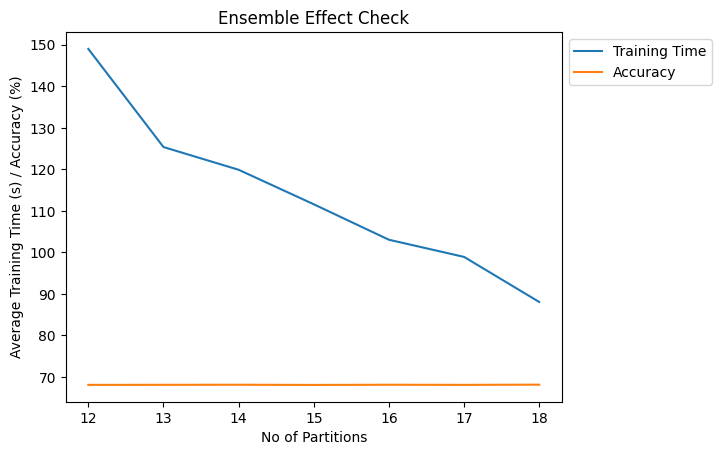

In [0]:
plt.plot(df2['no of partitions'], df2['avg training time'], label = 'Training Time')

plt.plot(df2['no of partitions'], df2['avg accuracy'], label = 'Accuracy')

plt.xlabel('No of Partitions')

plt.ylabel('Average Training Time (s) / Accuracy (%)')

plt.title('Ensemble Effect Check')

plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))

plt.show()

No improvement in accuracy was observed as the number of partitions increased. However, the average training time kept decreasing with increasing number of partitions

### Distribution of classes in each partition

In [0]:
def count_in_partition(idx, iterator):
    import collections
    count = collections.defaultdict(int)
    for row in iterator:
        count[row['sentiment']] += 1
    return [(idx, dict(count))]

In [0]:
train_df_rdd = train_df.rdd.repartition(18)

partition_counts = train_df_rdd.mapPartitionsWithIndex(count_in_partition).collect()

partition_counts

[(0, {'neutral': 20394, 'negative': 12848, 'positive': 15638}),
 (1, {'positive': 15681, 'neutral': 20301, 'negative': 12892}),
 (2, {'positive': 15901, 'negative': 12915, 'neutral': 20055}),
 (3, {'positive': 15688, 'neutral': 20343, 'negative': 12844}),
 (4, {'positive': 15436, 'negative': 13030, 'neutral': 20396}),
 (5, {'negative': 12864, 'positive': 15637, 'neutral': 20371}),
 (6, {'positive': 15750, 'neutral': 20461, 'negative': 12679}),
 (7, {'neutral': 20717, 'positive': 15507, 'negative': 12657}),
 (8, {'negative': 12715, 'neutral': 20337, 'positive': 15834}),
 (9, {'positive': 15824, 'neutral': 20515, 'negative': 12551}),
 (10, {'negative': 12806, 'neutral': 20335, 'positive': 15759}),
 (11, {'neutral': 20188, 'positive': 15799, 'negative': 12909}),
 (12, {'neutral': 20234, 'negative': 12769, 'positive': 15889}),
 (13, {'positive': 15679, 'negative': 12851, 'neutral': 20352}),
 (14, {'negative': 12639, 'neutral': 20240, 'positive': 16001}),
 (15, {'positive': 16057, 'negative

In [0]:
df3 = pd.DataFrame({
    'ID': [item[0] for item in partition_counts],
    'Neutral': [item[1]['neutral'] for item in partition_counts],
    'Positive': [item[1]['positive'] for item in partition_counts],
    'Negative': [item[1]['negative'] for item in partition_counts]
})

df3.head()

,ID,Neutral,Positive,Negative
0,0,20394,15638,12848
1,1,20301,15681,12892
2,2,20055,15901,12915
3,3,20343,15688,12844
4,4,20396,15436,13030


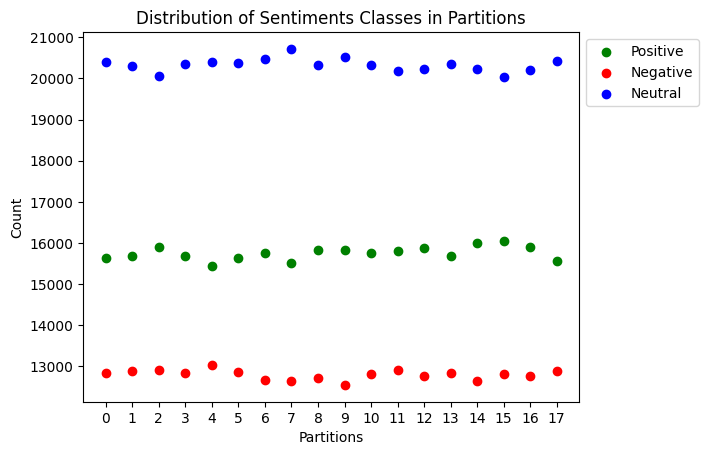

In [0]:
partitions = np.arange(18)

plt.scatter(df3['ID'], df3['Positive'], color = 'green', label = 'Positive')

plt.scatter(df3['ID'], df3['Negative'], color ='red', label = 'Negative')

plt.scatter(df3['ID'], df3['Neutral'], color = 'blue', label = 'Neutral')

plt.xticks(partitions)

plt.title('Distribution of Sentiments Classes in Partitions')

plt.xlabel('Partitions')

plt.ylabel('Count')

plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))

plt.show()


The distribution of each sentiment class is nearly identical across the 18 partitions 

### Size Up Experiment

#### First Run

In [0]:
experiment_result5 = []

sample_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for i in sample_list:
  
  sampled_train_rdd = model_data_train_rdd.sample(False, i)
  
  sampled_train_rdd = sampled_train_rdd.repartition(18)
  
  model_time_pairs = sampled_train_rdd.mapPartitions(build_model).collect()
  
  total_training_time = sum(time for _, time in model_time_pairs)
  
  experiment_result5.append((i, total_training_time))

In [0]:
experiment_result5

[(0.1, 56.58634543418884),
 (0.2, 292.26844239234924),
 (0.3, 400.319872379303),
 (0.4, 772.1286914348602),
 (0.5, 803.9578368663788),
 (0.6, 1063.779626607895),
 (0.7, 1294.8386180400848),
 (0.8, 1462.8523228168488),
 (0.9, 1389.662532567978),
 (1.0, 1643.1150197982788)]

#### Second Run

In [0]:
experiment_result6 = []

sample_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for i in sample_list:
  
  sampled_train_rdd = model_data_train_rdd.sample(False, i)
  
  sampled_train_rdd = sampled_train_rdd.repartition(18)
  
  model_time_pairs = sampled_train_rdd.mapPartitions(build_model).collect()
  
  total_training_time = sum(time for _, time in model_time_pairs)
  
  experiment_result6.append((i, total_training_time))

In [0]:
experiment_result6

[(0.1, 35.65650963783264),
 (0.2, 141.90135288238525),
 (0.3, 276.23421931266785),
 (0.4, 462.2063567638397),
 (0.5, 655.9277877807617),
 (0.6, 797.9795796871185),
 (0.7, 990.4201173782349),
 (0.8, 1176.8952322006226),
 (0.9, 1300.3573043346405),
 (1.0, 1548.2011456489563)]

In [0]:
def calculate_averages_list(a, b):

  result = []

  for tuple_a, tuple_b in zip(a, b):

    average_second = (tuple_a[1] + tuple_b[1]) / 2

    result_tuple = (tuple_a[0], average_second)

    result.append(result_tuple)

  return result

result2 = calculate_averages_list(experiment_result5, experiment_result6)

In [0]:
df4 = pd.DataFrame(result2, columns = ['size of data', 'Total Training Time'])

df4

,size of data,Total Training Time
0,0.1,46.121428
1,0.2,217.084898
2,0.3,338.277046
3,0.4,617.167524
4,0.5,729.942812
5,0.6,930.879603
6,0.7,1142.629368
7,0.8,1319.873778
8,0.9,1345.009918
9,1.0,1595.658083


In [0]:
df4['average training time'] = df4['Total Training Time'] / 18

df4['Real size up'] = df4['average training time'] / df4.iloc[0, 2]

df4['Linear size up'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

df4

,size of data,Total Training Time,average training time,Real size up,Linear size up
0,0.1,46.121428,2.562302,1.000000,1
1,0.2,217.084898,12.060272,4.706812,2
2,0.3,338.277046,18.793169,7.334488,3
3,0.4,617.167524,34.287085,13.381362,4
4,0.5,729.942812,40.552378,15.826544,5
5,0.6,930.879603,51.715534,20.183235,6
6,0.7,1142.629368,63.479409,24.774371,7
7,0.8,1319.873778,73.326321,28.617366,8
8,0.9,1345.009918,74.722773,29.162365,9
9,1.0,1595.658083,88.647671,34.596893,10


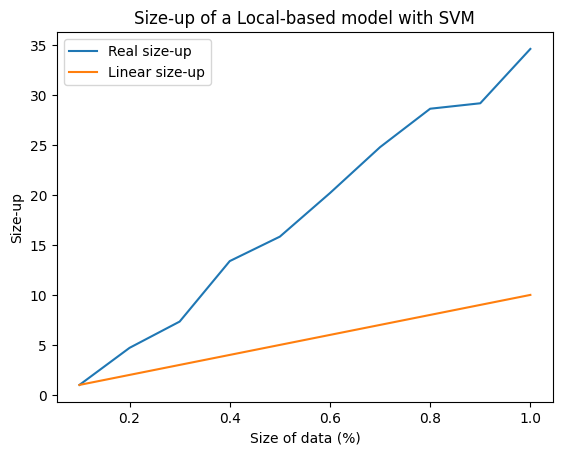

In [0]:
plt.plot(df4['size of data'], df4['Real size up'], label = 'Real size-up')

plt.plot(df4['size of data'], df4['Linear size up'], label = 'Linear size-up')

plt.xlabel('Size of data (%)')

plt.ylabel('Size-up')

plt.title('Size-up of a Local-based model with SVM')

plt.legend()

plt.show()

Our local approach doesn't scale linearly with increasing data sizes. This is primarily due to the time complexity of the Support Vector Machine Algorithm